### Calcular para cada tickets con cuanto tiempo de antelación se compró

In [1]:
lts = sc.textFile('../../Data/spark/transm150720.csv')

In [2]:
def getTCNFechaCompra(l):
    elems = l.split(",")
    tcn = elems[0]
    fechacompra = elems[9]
    return (tcn, fechacompra)

In [3]:
getTCNFechaCompra(lts.first())

(u'79062005698500', u'141025')

In [4]:
ts = lts.map(getTCNFechaCompra)

In [5]:
ts.take(3)

[(u'79062005698500', u'141025'),
 (u'79062005924069', u'150719'),
 (u'79065668570385', u'150626')]

In [7]:
lcs = sc.textFile('../../Data/spark/coupon150720.csv')

In [8]:
def getTCNFechaSalida(l):
    elems = l.split(",")
    tcn = elems[0]
    fechasalida = elems[12]
    return (tcn, fechasalida)

In [9]:
cs = lcs.map(getTCNFechaSalida)

In [10]:
cs.take(3)

[(u'79062005698500', u'150904'),
 (u'79062005698500', u'150905'),
 (u'79062005924069', u'150721')]

In [ ]:
#Hay claves repetidas, hacemos un group para tener sólo una y quedarnos con la fecha mas antigua.

In [ ]:
#groupbykey hace las agrupaciones de la misma clave en una misma particion en un mismo nodo, 
#por lo que podemos quedarnos sin memoria

In [11]:
cs.groupByKey().mapValues(lambda vs: min(vs)).take(3)

[(u'79062005558463', u'150801'),
 (u'79065668432713', u'150823'),
 (u'79062005501193', u'150720')]

In [15]:
cgps = cs.groupByKey().mapValues(lambda vs: min(vs)).cache()

In [16]:
cgps.take(3)

[(u'79062005558463', u'150801'),
 (u'79065668432713', u'150823'),
 (u'79062005501193', u'150720')]

In [17]:
j = cgps.leftOuterJoin(ts).cache()

In [18]:
j.take(3)

[(u'79062005994272', (u'150720', u'150719')),
 (u'79065668614400', (u'150724', u'150719')),
 (u'79062005501193', (u'150720', u'150719'))]

In [12]:
from time import strptime #convierte texto en fecha
from time import mktime #convierte una fecha en segundos

In [23]:
def difFechas(f1,f2):
    of1 = strptime(f1,'%y%m%d')
    of2 = strptime(f2,'%y%m%d')
    seg1 = mktime(of1)
    seg2 = mktime(of2)
    dif = seg1 - seg2
    return dif/(3600*24)

In [ ]:
#Eliminamos los elementos con fechas vacías, lo deberíamos haber hecho antes

In [21]:
fj = j.filter(lambda x: x[1][0] != '' and x[1][1] != '')

In [22]:
fj.take(3)

[(u'79062005994272', (u'150720', u'150719')),
 (u'79065668614400', (u'150724', u'150719')),
 (u'79062005501193', (u'150720', u'150719'))]

In [24]:
fj.mapValues(lambda v: difFechas(v[0], v[1])).take(3)

[(u'79062005994272', 1.0), (u'79065668614400', 5.0), (u'79062005501193', 1.0)]

In [25]:
d = fj.mapValues(lambda v: difFechas(v[0], v[1]))

In [26]:
d.groupBy(lambda x: x[1]).take(3) # No nos vale, hay que hacerlo con reduceByKey porque pueden salir grupos muy grandes. 
#aparte hay que eliminar los decimales

[(0.0, <pyspark.resultiterable.ResultIterable at 0x7f7da50492d0>),
 (750.0, <pyspark.resultiterable.ResultIterable at 0x7f7da4769610>),
 (198.04166666666666,
  <pyspark.resultiterable.ResultIterable at 0x7f7da4769690>)]

In [27]:
d.map(lambda x: (x[1],1)).take(3)

[(1.0, 1), (5.0, 1), (1.0, 1)]

In [30]:
r = d.map(lambda x: (int(x[1]),1)).reduceByKey(lambda x,acum: x+acum)

In [31]:
r.take(3)

[(0, 28366), (515, 1), (5, 16793)]

In [32]:
r.count()

452

In [33]:
res = r.collect() #recolectamos los datos a una lista

In [34]:
len(res)

452

In [35]:
type(res)

list

In [36]:
res[0:5]

[(0, 28366), (515, 1), (5, 16793), (10, 9906), (15, 7791)]

In [37]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [39]:
xs = [t[0] for t in res]

In [41]:
xs[0:5]

[0, 515, 5, 10, 15]

In [40]:
ys = [t[1] for t in res]

In [42]:
ys[0:5]

[28366, 1, 16793, 9906, 7791]

<Container object of 452 artists>

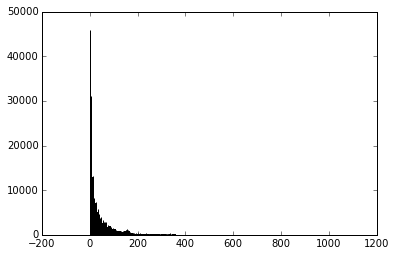

In [43]:
plt.bar(xs,ys)

(0, 90)

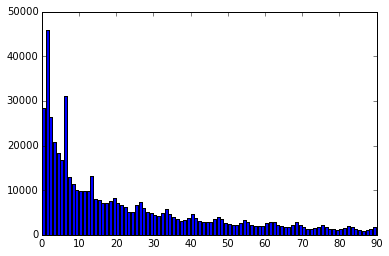

In [48]:
plt.bar(xs,ys)
plt.xlim(0,90)

### Ejercicio. Sacar el precio medio por día de antelacion

In [2]:
lts = sc.textFile('/home/dsc/Data/spark/transm150720.csv')

In [2]:
lcs = sc.textFile('/home/dsc/Data/spark/coupon150720.csv')

In [7]:
lts.first()

u'79062005698500,TKTT,30,150719,FR,0.0,EUR,T,T,141025,PARA127A8,0.0,EUR,   ,EX,,150719,0.0'

In [8]:
lcs.first()

u'79062005698500,1,MAA,AUH,9W,9W,56.79,USD,1,H,H,0526,150904,OK,IAF0'

In [3]:
def getTCNFechaCompraTs(l):
    elems = l.split(",")
    tcn = elems[0]
    fechacompra = elems[9]
    return (tcn,fechacompra)

In [4]:
def getTCNFechaSalidaPVP(l):
    elems = l.split(",")
    tcn = elems[0]
    fechasalida = elems[12]
    pvp = float(elems[6])
    return (tcn, fechasalida, pvp)

In [5]:
ts = lts.map(getTCNFechaCompraTs)

In [6]:
cs = lcs.map(getTCNFechaSalidaPVP)

In [14]:
ts.first()

(u'79062005698500', u'141025')

In [221]:
cs.first()

(u'79062005698500', u'150904', 56.79)

In [250]:
ts.filter(lambda x: x[1]=='None').take(3)

[]

In [7]:
ts = ts.filter(lambda x: x[1] != '')

In [224]:
cs.first()

(u'79062005698500', u'150904', 56.79)

In [8]:
cs = cs.filter(lambda x: x[1] != '')

In [42]:
cs.groupBy(lambda x: x[0]).take(3)

[(u'79062005558463',
  <pyspark.resultiterable.ResultIterable at 0x7f52445f6590>),
 (u'79065668432713',
  <pyspark.resultiterable.ResultIterable at 0x7f5244624390>),
 (u'79062005501193',
  <pyspark.resultiterable.ResultIterable at 0x7f5244624490>)]

In [228]:
cs.map(lambda x: (x[0],(x[1],x[2]))).groupByKey().mapValues(lambda x: x).take(3)

[(u'79062005558463',
  <pyspark.resultiterable.ResultIterable at 0x7f5245135f50>),
 (u'79065668432713',
  <pyspark.resultiterable.ResultIterable at 0x7f52446efbd0>),
 (u'79062005501193',
  <pyspark.resultiterable.ResultIterable at 0x7f52446ef610>)]

In [9]:
csr = cs.map(lambda x: (x[0],(x[1],x[2]))).reduceByKey(lambda x,acum: (min(x[0],acum[0]),x[1]+acum[1]))

In [230]:
csr.first()

(u'79062005558463', (u'150801', 0.0))

In [10]:
tc = csr.leftOuterJoin(ts)

In [232]:
tc.first()

(u'79062005994272', ((u'150720', 112.54), u'150719'))

In [11]:
from time import strptime
from time import mktime

In [12]:
def diferenciaFechas(x,y):
    if x == 'None' or y == 'None':
        return -1
    
    ox = strptime(x,'%y%m%d')
    oy = strptime(y,'%y%m%d')
    mx = mktime(ox)
    my = mktime(oy)
    dif = mx - my
    return dif/(3600*24)

In [101]:
tc.map(lambda (x,y): (y)).map(lambda (x,y): (x[0],x[1],y)).take(3)

[(u'150720', 112.54, u'150719'),
 (u'150724', 229.51000000000002, u'150719'),
 (u'150720', 272.96, u'150719')]

In [13]:
diaspvp = tc.map(lambda (x,y): (y)).map(lambda (x,y): (x[0],x[1],y))

In [234]:
diaspvp.first()

(u'150720', 112.54, u'150719')

In [14]:
difdiaspvp = diaspvp.map(lambda x: (int(diferenciaFechas(str(x[0]),str(x[2]))),x[1]))

In [205]:
difdiaspvp.take(3)

[(1, 112.54), (5, 229.51000000000002), (1, 272.96)]

In [206]:
difdiaspvp.map(lambda x: (x[0],(x[1],1))).take(3)

[(1, (112.54, 1)), (5, (229.51000000000002, 1)), (1, (272.96, 1))]

In [15]:
mapdifdiaspvp = difdiaspvp.map(lambda x: (x[0],(x[1],1)))

In [241]:
mapdifdiaspvp.take(3)

[(1, (112.54, 1)), (5, (229.51000000000002, 1)), (1, (272.96, 1))]

In [18]:
mapdifdiaspvp.reduceByKey(lambda x,y: (x[0]+y[0],y[1]+1)).take(3)

[(0, (6070913.1699999925, 3)),
 (515, (327.32, 1)),
 (5, (4177215.5900000087, 3))]

In [17]:
mapdifdiaspvp.reduceByKey(lambda x,y: (x[0]+y[0],y[1]+1)).cache()

PythonRDD[24] at RDD at PythonRDD.scala:43

In [25]:
lista_pvp_n = mapdifdiaspvp.reduceByKey(lambda x,y: (x[0]+y[0],y[1]+1))

In [21]:
lista_pvp_n.map(lambda x: (x[0],x[1][0]/x[1][1])).take(3)

[(0, 2023637.7233333308), (515, 327.32), (5, 1392405.1966666696)]

In [26]:
media = lista_pvp_n.map(lambda x: (x[0],x[1][0]/x[1][1])).collect()

In [27]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [28]:
xs = [t[0] for t in media]

In [31]:
ys = [t[1] for t in media]

<Container object of 452 artists>

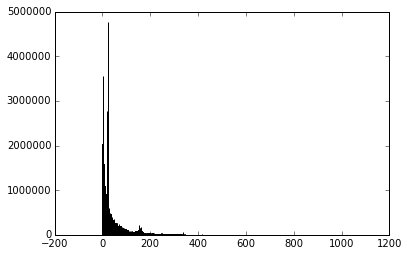

In [32]:
plt.bar(xs,ys)

(0, 40)

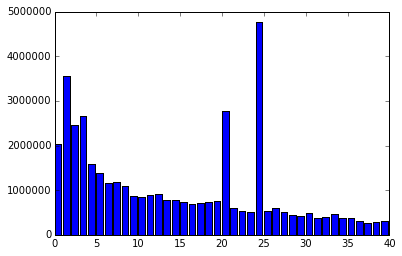

In [41]:
plt.bar(xs,ys)
plt.xlim(0,40)

In [49]:
sorted(media, key = lambda x: x[1], reverse = True)

[(24, 4759034.123333336),
 (1, 3553273.0799999796),
 (20, 2779497.019999997),
 (3, 2662138.590000002),
 (2, 2458512.4999999907),
 (0, 2023637.7233333308),
 (4, 1583155.3866666697),
 (5, 1392405.1966666696),
 (7, 1181126.0766666678),
 (6, 1168300.610000001),
 (8, 1096465.4266666677),
 (12, 907169.1333333332),
 (11, 890133.4933333333),
 (9, 859636.883333333),
 (10, 854746.7599999998),
 (13, 781420.356666666),
 (14, 772182.5533333322),
 (19, 747532.203333333),
 (18, 732393.2566666672),
 (15, 730657.0399999995),
 (17, 708601.056666667),
 (16, 686699.8733333327),
 (26, 610755.0566666665),
 (21, 609130.43),
 (25, 542474.9333333335),
 (22, 535715.5400000004),
 (27, 521851.0666666665),
 (23, 500482.1433333337),
 (30, 496476.12000000005),
 (33, 459273.80333333364),
 (28, 451264.21333333384),
 (29, 411156.00000000006),
 (40, 403861.166666667),
 (32, 398982.98666666687),
 (34, 385861.99666666676),
 (31, 381842.65000000014),
 (35, 369273.95333333337),
 (47, 345790.1600000003),
 (46, 325223.4533333

### Dia de la semana que se hacen mas reservas

In [45]:
import datetime
import numpy as np

In [20]:
fecha = lts.map(lambda x: (x.split(',')[9],1))

In [10]:
fecha.take(3)

[(u'141025', 1), (u'150719', 1), (u'150626', 1)]

In [23]:
def getDia(d):
    if d == '':
        return 'Fallo'
    return datetime.datetime.strptime(d, '%y%m%d').strftime('%A')

In [24]:
dias = fecha.map(lambda x: (getDia(x[0]),x[1]))

In [30]:
resul = dias.reduceByKey(lambda x,y: x+y).collect()

In [57]:
resul = sorted(resul, key = lambda x: x[1], reverse = True)

In [58]:
xs = [x[0] for x in resul]

In [59]:
ys = [x[1] for x in resul]

In [60]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


([<matplotlib.axis.XTick at 0x7ff5816be490>,
 <a list of 8 Text xticklabel objects>)

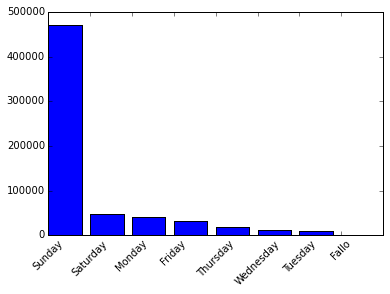

In [61]:
plt.bar(np.arange(len(xs)),ys)
plt.xticks(np.arange(len(xs)),xs, rotation = 45)

In [62]:
resul

[('Sunday', 470775),
 ('Saturday', 48575),
 ('Monday', 39841),
 ('Friday', 32483),
 ('Thursday', 17370),
 ('Wednesday', 11837),
 ('Tuesday', 10515),
 ('Fallo', 9)]